# Simple supernova lightcurve

In [2]:
import numpy as np
import matplotlib.pyplot as plt

A simple model of a supernova lightcurve is just to add up the energy of the photons that result from the decay:

$${}^{56}\mathrm{Ni} \rightarrow {}^{56}\mathrm{Co} \rightarrow {}^{56}\mathrm{Fe}$$

The evolution equations for the number densities appear as:

\begin{align*}
\frac{dn_\mathrm{Ni}}{dt} &= -\lambda_\mathrm{Ni} n_\mathrm{Ni} \\
\frac{dn_\mathrm{Co}}{dt} &= +\lambda_\mathrm{Ni} n_\mathrm{Ni} - \lambda_\mathrm{Co} n_\mathrm{Co}
\end{align*}

where $\lambda_\mathrm{Ni}$ is the decay constant for ${}^{56}\mathrm{Ni}$ and $\lambda_\mathrm{Co}$
is the decay constant for ${}^{56}\mathrm{Co}$.

The initial conditions are:

\begin{align*}
n_\mathrm{Ni}(t = 0) &= n_0 \\
n_\mathrm{Co}(t = 0) &= 0
\end{align*}

We can integrate the Ni equation directly, giving:

$$n_\mathrm{Ni} = n_0 e^{-\lambda_\mathrm{Ni} t}$$

then the Co equation becomes:

$$\frac{dn_\mathrm{Co}}{dt} = \lambda_\mathrm{Ni} n_0 e^{-\lambda_\mathrm{Ni} t} - \lambda_\mathrm{Co} n_\mathrm{Co}$$

This can be integrated by applying an integrating factor:

$$\frac{d}{dt} \left ( e^{\lambda_\mathrm{Co} t} n_\mathrm{Co} \right ) =
    e^{\lambda_\mathrm{Co} t} \frac{dn_\mathrm{Co}}{dt} + \lambda_\mathrm{Co} e^{\lambda_\mathrm{Co} t} n_\mathrm{Co} = e^{\lambda_\mathrm{Co} t} \left [ \frac{dn_\mathrm{Co}}{dt} + \lambda_\mathrm{Co} n_\mathrm{Co} \right ]$$
    
Now the term in the $[ \ldots ]$ is just $\lambda_\mathrm{Ni} n_\mathrm{Ni}$, so this becomes:

$$\frac{d}{dt} \left ( e^{\lambda_\mathrm{Co} t} n_\mathrm{Co} \right ) =
    e^{\lambda_\mathrm{Co} t} \lambda_\mathrm{Ni} n_0 e^{-\lambda_\mathrm{Ni} t}$$
    
This gives:

$$n_\mathrm{Co} = \frac{\lambda_\mathrm{Ni}}{\lambda_\mathrm{Co} - \lambda_\mathrm{Ni}}
    n_0 \left ( e^{-\lambda_\mathrm{Ni} t} - e^{-\lambda_\mathrm{Co} t} \right )$$

With these number densities, we can get the total amount of Ni or Co at any point in time:

$$N_\mathrm{Ni} = n_\mathrm{Ni} V = \frac{X_\mathrm{Ni} \rho}{m_\mathrm{Ni}} V = \frac{X_\mathrm{Ni} M_\mathrm{exp}}{m_\mathrm{Ni}}$$

and

$$N_\mathrm{Co} = \frac{X_\mathrm{Co} M_\mathrm{exp}}{m_\mathrm{Co}}$$

This gives:

\begin{align*}
L(t) &= -Q_\mathrm{Ni} (-\lambda_\mathrm{Ni} N_\mathrm{Ni} ) - Q_\mathrm{Co} (-\lambda_\mathrm{Co} N_\mathrm{Co} ) \\
     &\approx \left [ Q_\mathrm{Ni} \lambda_\mathrm{Ni} X_\mathrm{Ni} + Q_\mathrm{Co} \lambda_\mathrm{Co} X_\mathrm{Co} \right ] \frac{M_\mathrm{exp}}{m_{56}}
\end{align*}

where $m_{56}$ is just $56 m_u$, with $m_u$ the atomic mass unit (this approximates the mass of Ni and Co).

## Implementation

some physical constants

In [33]:
seconds_per_day = 24*3600
erg_per_MeV = 1.6e-12*1.e6
m_u = 1.66e-24     # CGS

solar_mass = 2.e33          # CGS
solar_luminosity = 4.e33    # CGS

the core `LightCurve` class

In [34]:
class LightCurve:
    def __init__(self, M_exp, *, X_Ni_0=1.0):

        """create the lightcurve.  Here, M_exp is the mass of ejecta in grams"""
        self.M_exp = M_exp
        self.X_Ni_0 = X_Ni_0

        # note: see Nadyozhin 1994, ApJ, 92, 527 for Q values of
        # just photons.  They suggest Q_Ni = 1.75 MeV, Q_Co = 3.73 MeV

        thalf_Ni = 6.1 * seconds_per_day      # half-life of Ni-56
        self.lambda_Ni = np.log(2) / thalf_Ni
        self.Q_Ni = 1.75 * erg_per_MeV
        self.m_Ni = 56 * m_u

        thalf_Co = 77.1*seconds_per_day     # half-life of Co-56
        self.lambda_Co = np.log(2) / thalf_Co
        self.Q_Co = 3.73 * erg_per_MeV
        self.m_Co = 56 * m_u

    def X_Ni(self, t):
        return self.X_Ni_0 * np.exp(-self.lambda_Ni * t)

    def X_Co(self, t):
        return (self.lambda_Ni / (self.lambda_Co - self.lambda_Ni) * self.X_Ni_0 *
                (np.exp(-self.lambda_Ni * t) - np.exp(-self.lambda_Co * t)))

    def L(self, t):
        return (self.Q_Ni * self.M_exp / self.m_Ni * self.lambda_Ni * self.X_Ni(t) +
                self.Q_Co * self.M_exp / self.m_Co * self.lambda_Co * self.X_Co(t))

## Lightcurve from $1~M_\odot$ of ${}^{56}\mathrm{Ni}$

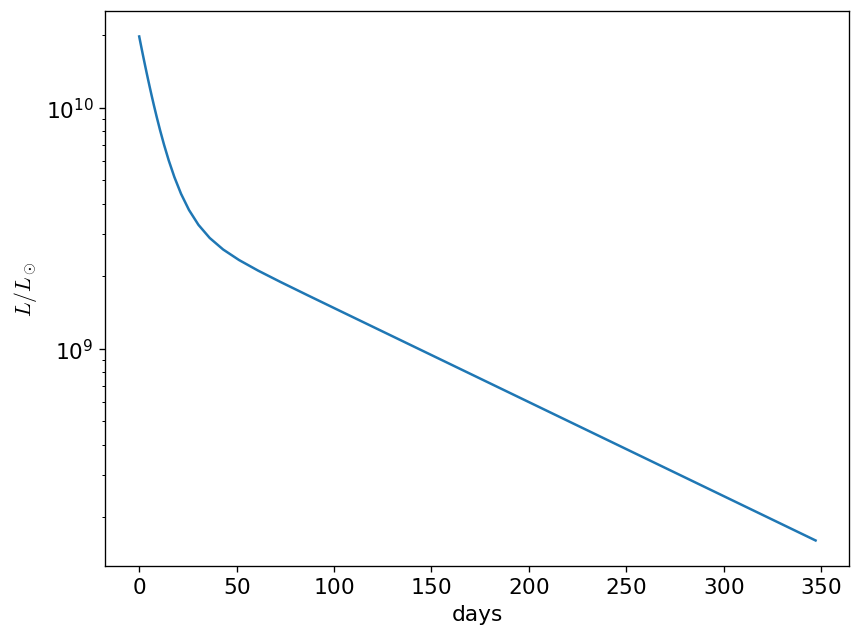

In [35]:
# initial condition
M_exp = 1.0*solar_mass

lc = LightCurve(M_exp)
t = np.logspace(np.log10(1.0), np.log10(3.e7), 100)

fig, ax = plt.subplots()
ax.plot(t / seconds_per_day, lc.L(t) / solar_luminosity)

ax.set_xlabel("days")
ax.set_ylabel(r"$L/L_\odot$")

ax.set_yscale("log")

## Different masses of ${}^{56}\mathrm{Ni}$

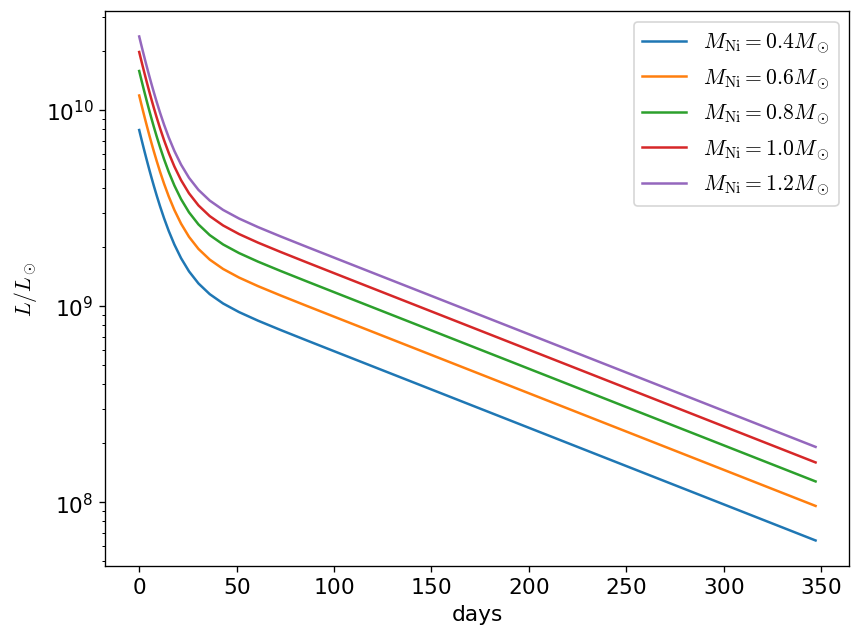

In [36]:
fig, ax = plt.subplots()
t = np.logspace(np.log10(1.0), np.log10(3.e7), 100)

for mass in [0.4, 0.6, 0.8, 1.0, 1.2]:
    lc = LightCurve(mass * solar_mass)
    ax.plot(t / seconds_per_day, lc.L(t) / solar_luminosity,
            label=f"$M_\mathrm{{Ni}} = {mass} M_\odot$")
    
ax.set_yscale("log")
ax.set_xlabel("days")
ax.set_ylabel(r"$L/L_\odot$")
ax.legend()